In [1]:
import time
start_time = time.time()

import datetime
now = datetime.datetime.now()
print(f"Starting execution at: {now.hour}:{now.minute}")

Starting execution at: 11:9


In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt


# Constants
mpi = 140.
mK = 494.
mD = 1865.
mJp = 3097.
mp2S = 3686.
mB = 5280.
probK_all = 0.5
probK_high = 0.8
probK_sum = 2.1
probK_max = 0.7
probpi_all = 0.6
probpi_sum2 = 1.3
probpi_sum = 2.4
mass_cut = 50.
mass_cut_D = 20.

print('Done!')

Done!


In [3]:
print("Starting RDataFrame processing with two files...")

# Enable implicit multi-threading for RDataFrame
# ROOT.EnableImplicitMT()

# Create a TChain to combine both files
chain = ROOT.TChain("DecayTree")
chain.Add("../data/B2HHH_MagnetDown.root")
chain.Add("../data/B2HHH_MagnetUp.root")
# chain.Add("500k_B2HHH_MagnetUp.root")

# Load the combined data using RDataFrame
df = ROOT.RDataFrame(chain)

# First, let's check the total number of events from both files
total_events = df.Count()
# print(f"Total events in combined files: {total_events}")

# --- Define derived quantities (exactly matching the uproot code) ---

# Define pT calculations
df = df.Define("pT_H1", "sqrt(H1_PX*H1_PX + H1_PY*H1_PY)")
df = df.Define("pT_H2", "sqrt(H2_PX*H2_PX + H2_PY*H2_PY)")
df = df.Define("pT_H3", "sqrt(H3_PX*H3_PX + H3_PY*H3_PY)")

# Define energy calculations for pions
df = df.Define("e_pi1", f"sqrt(H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ + {mpi*mpi})")\
       .Define("e_pi2", f"sqrt(H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ + {mpi*mpi})")\
       .Define("e_pi3", f"sqrt(H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ + {mpi*mpi})")

# Define energy calculations for kaons
df = df.Define("e_K1", f"sqrt(H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ + {mK*mK})")\
       .Define("e_K2", f"sqrt(H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ + {mK*mK})")\
       .Define("e_K3", f"sqrt(H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ + {mK*mK})")

# Define momentum squared calculations
df = df.Define("p12sq", "(H1_PX + H2_PX)*(H1_PX + H2_PX) + (H1_PY + H2_PY)*(H1_PY + H2_PY) + (H1_PZ + H2_PZ)*(H1_PZ + H2_PZ)")\
       .Define("p23sq", "(H2_PX + H3_PX)*(H2_PX + H3_PX) + (H2_PY + H3_PY)*(H2_PY + H3_PY) + (H2_PZ + H3_PZ)*(H2_PZ + H3_PZ)")\
       .Define("p13sq", "(H1_PX + H3_PX)*(H1_PX + H3_PX) + (H1_PY + H3_PY)*(H1_PY + H3_PY) + (H1_PZ + H3_PZ)*(H1_PZ + H3_PZ)")\
       .Define("psq", "(H1_PX + H2_PX + H3_PX)*(H1_PX + H2_PX + H3_PX) + (H1_PY + H2_PY + H3_PY)*(H1_PY + H2_PY + H3_PY) + (H1_PZ + H2_PZ + H3_PZ)*(H1_PZ + H2_PZ + H3_PZ)")

# Define mass squared calculations for KK pairs
df = df.Define("m12KKsq", "(e_K1 + e_K2)*(e_K1 + e_K2) - p12sq")\
       .Define("m23KKsq", "(e_K2 + e_K3)*(e_K2 + e_K3) - p23sq")\
       .Define("m13KKsq", "(e_K1 + e_K3)*(e_K1 + e_K3) - p13sq")

# Define mass squared calculations for pipi pairs
df = df.Define("m12pipisq", "(e_pi1 + e_pi2)*(e_pi1 + e_pi2) - p12sq")\
       .Define("m23pipisq", "(e_pi2 + e_pi3)*(e_pi2 + e_pi3) - p23sq")\
       .Define("m13pipisq", "(e_pi1 + e_pi3)*(e_pi1 + e_pi3) - p13sq")

# Define mass squared calculations for Kpi pairs
# TODO line 2+5
df = df.Define("m12Kpisq", "(e_K1 + e_pi2)*(e_K1 + e_pi2) - p12sq")\
       .Define("m23Kpisq", "(e_K3 + e_pi2)*(e_K3 + e_pi2) - p23sq")\
       .Define("m13Kpisq", "(e_K1 + e_pi3)*(e_K1 + e_pi3) - p13sq")\
       .Define("m12piKsq", "(e_pi1 + e_K2)*(e_pi1 + e_K2) - p12sq")\
       .Define("m23piKsq", "(e_pi3 + e_K2)*(e_pi3 + e_K2) - p23sq")\
       .Define("m13piKsq", "(e_pi1 + e_K3)*(e_pi1 + e_K3) - p13sq")

# Define invariant mass calculations
df = df.Define("mKKKinv", "sqrt((e_K1 + e_K2 + e_K3)*(e_K1 + e_K2 + e_K3) - psq)")\
       .Define("mpipipiinv", "sqrt((e_pi1 + e_pi2 + e_pi3)*(e_pi1 + e_pi2 + e_pi3) - psq)")\
       .Define("mKpipiinv", "sqrt((e_K1 + e_pi2 + e_pi3)*(e_K1 + e_pi2 + e_pi3) - psq)")\
       .Define("mpiKpiinv", "sqrt((e_pi1 + e_K2 + e_pi3)*(e_pi1 + e_K2 + e_pi3) - psq)")\
       .Define("mpipiKinv", "sqrt((e_pi1 + e_pi2 + e_K3)*(e_pi1 + e_pi2 + e_K3) - psq)")      
print("Derived quantities defined")
print('Done!')

Starting RDataFrame processing with two files...
Derived quantities defined
Done!


In [4]:
# --- Apply basic selection cuts ---
print("Applying basic selection criteria...")

# Filter basic cuts
df_basic = df.Filter("H1_PZ > 0 && H2_PZ > 0 && H3_PZ > 0", "Positive PZ")\
             .Filter("!H1_isMuon && !H2_isMuon && !H3_isMuon", "Not muons")

    
basic_events = df_basic.Count()
# print(f"Events after basic cuts: {basic_events.GetValue()}")
print('Done!')

Applying basic selection criteria...
Done!


In [5]:
#####################################################################
# Define mKKlow and mKKhigh for KKK histograms (matching original logic exactly)
df_basic = df_basic.Define("mKKlow", f"""
    double result = -999.0;
    bool in_mass_window = abs(mKKKinv - {mB}) < {mass_cut};
    bool probK_cuts = (H1_ProbK > {probK_all} && H2_ProbK > {probK_all} && H3_ProbK > {probK_all} && 
                       H1_ProbK + H2_ProbK + H3_ProbK > {probK_sum});
    
    if (probK_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            if (m13KKsq > m23KKsq) {{
                result = m23KKsq;  // mass² olarak sakla (sqrt() YOK!)
            }} else {{
                result = m13KKsq;  // mass² olarak sakla (sqrt() YOK!)
            }}
        }} else if (H1_Charge == H3_Charge) {{
            if (m12KKsq > m23KKsq) {{
                result = m23KKsq;  // mass² olarak sakla
            }} else {{
                result = m12KKsq;  // mass² olarak sakla
            }}
        }} else if (H2_Charge == H3_Charge) {{
            if (m12KKsq > m13KKsq) {{
                result = m13KKsq;  // mass² olarak sakla
            }} else {{
                result = m12KKsq;  // mass² olarak sakla
            }}
        }}
    }}
    return result;
""")

# TODO
df_basic = df_basic.Define("mKKhigh", f"""
    double result = -999.0;
    bool in_mass_window = abs(mKKKinv - {mB}) < {mass_cut};
    bool probK_cuts = (H1_ProbK > {probK_all} && H2_ProbK > {probK_all} && H3_ProbK > {probK_all} && 
                       H1_ProbK + H2_ProbK + H3_ProbK > {probK_sum});
    
    if (probK_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            if (m13KKsq > m23KKsq) {{
                result = m13KKsq;  // mass² olarak sakla (sqrt() YOK!)
            }} else {{
                result = m23KKsq;  // mass² olarak sakla (sqrt() YOK!)
            }}
        }} else if (H1_Charge == H3_Charge) {{
            if (m12KKsq > m23KKsq) {{
                result = m12KKsq;  // mass² olarak sakla
            }} else {{
                result = m23KKsq;  // mass² olarak sakla
            }}
        }} else if (H2_Charge == H3_Charge) {{
            if (m12KKsq > m13KKsq) {{
                result = m12KKsq;  // mass² olarak sakla
            }} else {{
                result = m13KKsq;  // mass² olarak sakla
            }}
        }}
    }}
    return result;
""")

# df_basic = df_basic.Define("mKKhigh", f"""
#     double result = -999.0;
#     bool in_mass_window = abs(mKKKinv - {mB}) < {mass_cut};
#     bool probK_cuts = (H1_ProbK > {probK_all} && H2_ProbK > {probK_all} && H3_ProbK > {probK_all} && 
#                        H1_ProbK + H2_ProbK + H3_ProbK > {probK_sum});
    
#     if (probK_cuts && in_mass_window) {{
#         if (H1_Charge == H2_Charge) {{
#             result = m12KKsq;  // mass² olarak sakla (sqrt() YOK!)
#         }} else if (H1_Charge == H3_Charge) {{
#             result = m13KKsq;  // mass² olarak sakla
#         }} else if (H2_Charge == H3_Charge) {{
#             result = m23KKsq;  // mass² olarak sakla
#         }}
#     }}
#     return result;
# """)

# Define mpipilow and mpipihigh for πππ histograms (matching original logic exactly)
df_basic = df_basic.Define("mpipilow", f"""
    double result = -999.0;
    bool in_mass_window = abs(mpipipiinv - {mB}) < {mass_cut};
    bool probPi_cuts = (H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
                        H1_ProbK < {probK_max} && H2_ProbK < {probK_max} && H3_ProbK < {probK_max} &&
                        H1_ProbPi + H2_ProbPi + H3_ProbPi > {probpi_sum});
    
    if (probPi_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            if (m13pipisq > m23pipisq) {{
                result = m23pipisq;  // mass² olarak sakla (sqrt() YOK!)
            }} else {{
                result = m13pipisq;  // mass² olarak sakla
            }}
        }} else if (H1_Charge == H3_Charge) {{
            if (m12pipisq > m23pipisq) {{
                result = m23pipisq;  // mass² olarak sakla
            }} else {{
                result = m12pipisq;  // mass² olarak sakla
            }}
        }} else if (H2_Charge == H3_Charge) {{
            if (m12pipisq > m13pipisq) {{
                result = m13pipisq;  // mass² olarak sakla
            }} else {{
                result = m12pipisq;  // mass² olarak sakla
            }}
        }}
    }}
    return result;
""")

df_basic = df_basic.Define("mpipihigh", f"""
    double result = -999.0;
    bool in_mass_window = abs(mpipipiinv - {mB}) < {mass_cut};
    bool probPi_cuts = (H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
                        H1_ProbK < {probK_max} && H2_ProbK < {probK_max} && H3_ProbK < {probK_max} &&
                        H1_ProbPi + H2_ProbPi + H3_ProbPi > {probpi_sum});
    
    if (probPi_cuts && in_mass_window) {{
        if (H1_Charge == H2_Charge) {{
            if (m13pipisq > m23pipisq) {{
                result = m13pipisq;  // mass² olarak sakla (sqrt() YOK!)
            }} else {{
                result = m23pipisq;  // mass² olarak sakla
            }}
        }} else if (H1_Charge == H3_Charge) {{
            if (m12pipisq > m23pipisq) {{
                result = m12pipisq;  // mass² olarak sakla
            }} else {{
                result = m23pipisq;  // mass² olarak sakla
            }}
        }} else if (H2_Charge == H3_Charge) {{
            if (m12pipisq > m13pipisq) {{
                result = m12pipisq;  // mass² olarak sakla
            }} else {{
                result = m13pipisq;  // mass² olarak sakla
            }}
        }}
    }}
    return result;
""")

# Define mKpi for Kππ histograms (matching original logic exactly)
df_basic = df_basic.Define("mKpi", f"""
    double result = -999.0;
    double max_probK = std::max({{H1_ProbK, H2_ProbK, H3_ProbK}});
    int kpi_case = 0;
    
    // Determine which case applies (matching original logic)
    if (H1_ProbK == max_probK && H1_ProbK > {probK_high} &&
        H2_Charge != H3_Charge &&
        H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
        (H2_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 1;
    }} else if (H2_ProbK == max_probK && H2_ProbK > {probK_high} &&
               H1_Charge != H3_Charge &&
               H1_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
               (H1_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 2;
    }} else if (H3_ProbK == max_probK && H3_ProbK > {probK_high} &&
               H1_Charge != H2_Charge &&
               H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} &&
               (H1_ProbPi + H2_ProbPi) > {probpi_sum2}) {{
        kpi_case = 3;
    }}
    
    bool in_mass_window = false;
    if (kpi_case == 1) {{
        in_mass_window = abs(mKpipiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            if (H1_Charge != H2_Charge) {{
                result = m12Kpisq;  // mass² olarak sakla (sqrt() YOK!)
            }} else {{
                result = m13Kpisq;  // mass² olarak sakla
            }}
        }}
    }} else if (kpi_case == 2) {{
        in_mass_window = abs(mpiKpiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            if (H2_Charge != H1_Charge) {{
                result = m12piKsq;  // mass² olarak sakla
            }} else {{
                result = m23Kpisq;  // mass² olarak sakla
            }}
        }}
    }} else if (kpi_case == 3) {{
        in_mass_window = abs(mpipiKinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            if (H3_Charge != H1_Charge) {{
                result = m13piKsq;  // mass² olarak sakla
            }} else {{
                result = m23piKsq;  // mass² olarak sakla
            }}
        }}
    }}
    
    return result;
""")

# Define mpipi for Kππ histograms (matching original logic exactly)
df_basic = df_basic.Define("mpipi", f"""
    double result = -999.0;
    double max_probK = std::max({{H1_ProbK, H2_ProbK, H3_ProbK}});
    int kpi_case = 0;
    
    // Determine which case applies (matching original logic)
    if (H1_ProbK == max_probK && H1_ProbK > {probK_high} &&
        H2_Charge != H3_Charge &&
        H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
        (H2_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 1;
    }} else if (H2_ProbK == max_probK && H2_ProbK > {probK_high} &&
               H1_Charge != H3_Charge &&
               H1_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
               (H1_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        kpi_case = 2;
    }} else if (H3_ProbK == max_probK && H3_ProbK > {probK_high} &&
               H1_Charge != H2_Charge &&
               H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} &&
               (H1_ProbPi + H2_ProbPi) > {probpi_sum2}) {{
        kpi_case = 3;
    }}
    
    bool in_mass_window = false;
    if (kpi_case == 1) {{
        in_mass_window = abs(mKpipiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            result = m23pipisq;  // mass² olarak sakla (sqrt() YOK!)
        }}
    }} else if (kpi_case == 2) {{
        in_mass_window = abs(mpiKpiinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            result = m13pipisq;  // mass² olarak sakla
        }}
    }} else if (kpi_case == 3) {{
        in_mass_window = abs(mpipiKinv - {mB}) < {mass_cut};
        if (in_mass_window) {{
            result = m12pipisq;  // mass² olarak sakla
        }}
    }}
    
    return result;
""")
print("Missing histogram variables defined")

# --- KKK Selection ---
print("Applying KKK selection...")

df_kkk = df_basic.Filter(f"H1_ProbK > {probK_all} && H2_ProbK > {probK_all} && H3_ProbK > {probK_all}", "KKK_ProbK_all")\
                 .Filter(f"H1_ProbK + H2_ProbK + H3_ProbK > {probK_sum}", "KKK_ProbK_sum")

# Define KKK mass selection with charge logic
df_kkk = df_kkk.Define("KKK_valid_mass", f"""
    double result = -999.0;
    bool mass_cut_ok = false;
    bool d_veto_ok = false;
    
    // H1-H2 same charge
    if (H1_Charge == H2_Charge) {{
        if (m13KKsq > m23KKsq) {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m23KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }} else {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m13KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }}
    }}
    // H1-H3 same charge
    else if (H1_Charge == H3_Charge) {{
        if (m12KKsq > m23KKsq) {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m23KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }} else {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m12KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }}
    }}
    // H2-H3 same charge
    else if (H2_Charge == H3_Charge) {{
        if (m12KKsq > m13KKsq) {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m13KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }} else {{
            if (abs(mKKKinv - {mB}) < {mass_cut}) mass_cut_ok = true;
            if (abs(sqrt(m12KKsq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
        }}
    }}
    
    if (d_veto_ok) result = mKKKinv;
    return result;
""")

# Define KKK mlow and mhigh for histograms
df_kkk = df_kkk.Define("KKK_mlow", """
    double result = -999.0;
    // Replicate logic to compute the low KK sq (without sqrt!)
    if (H1_Charge == H2_Charge) {
        if (m13KKsq > m23KKsq) {
            result = m23KKsq;  // mass² olarak sakla
        } else {
            result = m13KKsq;  // mass² olarak sakla
        }
    } else if (H1_Charge == H3_Charge) {
        if (m12KKsq > m23KKsq) {
            result = m23KKsq;
        } else {
            result = m12KKsq;
        }
    } else if (H2_Charge == H3_Charge) {
        if (m12KKsq > m13KKsq) {
            result = m13KKsq;
        } else {
            result = m12KKsq;
        }
    }
    return result;
""")\
.Define("KKK_mhigh", """
    double result = -999.0;
    // Compute the high KK sq (without sqrt!)
    if (H1_Charge == H2_Charge) {
        result = m12KKsq;  // mass² olarak sakla
    } else if (H1_Charge == H3_Charge) {
        result = m13KKsq;
    } else if (H2_Charge == H3_Charge) {
        result = m23KKsq;
    }
    return result;
""")
print('Done!')

Missing histogram variables defined
Applying KKK selection...
Done!


In [6]:
#df_kkk.Report()

In [7]:
# Add filter for mass window to collect mlow/mhigh only for events in B mass window
df_kkk_mass_window = df_kkk.Filter(f"abs(mKKKinv - {mB}) < {mass_cut}", "KKK_mass_window")
df_kkk_selected = df_kkk.Filter("KKK_valid_mass > 0", "KKK_final_selection")

report_kkk_mass_window = df_kkk_mass_window.Report()
report_kkk_selected = df_kkk_selected.Report()

kkk_candidates = df_kkk.Count()
kkk_selected = df_kkk_selected.Count()
kkk_mass_window = df_kkk_mass_window.Count()

# print(f"KKK candidates: {kkk_candidates}, in mass window: {kkk_mass_window}, selected: {kkk_selected}")
print('Done!')

Done!


In [8]:
# --- πππ Selection ---
print("Applying πππ selection...")

df_pipipi = df_basic.Filter(f"H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all}", "PIPIPI_ProbPi_all")\
                    .Filter(f"H1_ProbK < {probK_max} && H2_ProbK < {probK_max} && H3_ProbK < {probK_max}", "PIPIPI_ProbK_veto")\
                    .Filter(f"H1_ProbPi + H2_ProbPi + H3_ProbPi > {probpi_sum}", "PIPIPI_ProbPi_sum")


# Define πππ mass selection with charge logic
# TODO
# df_pipipi = df_pipipi.Define("PIPIPI_valid_mass", f"""
#     double result = -999.0;
#     bool mass_cut_ok = false;
#     bool d_veto_ok = false;
    
#     // H1-H2 same charge
#     if (H1_Charge == H2_Charge) {{
#         if (abs(mpipipiinv - {mB}) < {mass_cut}) mass_cut_ok = true;
#         if (abs(sqrt(m13pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m23pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
#     }}
#     // H1-H3 same charge
#     else if (H1_Charge == H3_Charge) {{
#         if (abs(mpipipiinv - {mB}) < {mass_cut}) mass_cut_ok = true;
#         if (abs(sqrt(m12pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m23pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
#     }}
#     // H2-H3 same charge
#     else if (H2_Charge == H3_Charge) {{
#         if (abs(mpipipiinv - {mB}) < {mass_cut}) mass_cut_ok = true;
#         if (abs(sqrt(m13pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m12pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
#     }}
    
#     if (d_veto_ok) result = mpipipiinv;
#     return result;
# """)

# TODO sqrt
df_pipipi = df_pipipi.Define("PIPIPI_valid_mass", f"""
    double result = -999.0;
    bool d_veto_ok = false;
    
    // H1-H2 same charge
    if (H1_Charge == H2_Charge) {{
        if (abs(sqrt(m13pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m23pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
    }}
    // H1-H3 same charge
    else if (H1_Charge == H3_Charge) {{
        if (abs(sqrt(m12pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m23pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
    }}
    // H2-H3 same charge
    else if (H2_Charge == H3_Charge) {{
        if (abs(sqrt(m13pipisq) - {mD}) > {mass_cut_D} && abs(sqrt(m12pipisq) - {mD}) > {mass_cut_D}) d_veto_ok = true;
    }}
    
    if (d_veto_ok) result = mpipipiinv;
    return result;
""")


# Define πππ mlow and mhigh for histograms - DÜZELTİLDİ (mass² olarak sakla)
df_pipipi = df_pipipi.Define("PIPIPI_mlow", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        result = std::min(m13pipisq, m23pipisq);  // mass² olarak sakla
    } else if (H1_Charge == H3_Charge) {
        result = std::min(m12pipisq, m23pipisq);  // mass² olarak sakla
    } else if (H2_Charge == H3_Charge) {
        result = std::min(m12pipisq, m13pipisq);  // mass² olarak sakla
    }
    return result;
""")
df_pipipi = df_pipipi.Define("PIPIPI_mhigh", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        result = std::max(m13pipisq, m23pipisq);  // mass² olarak sakla
    } else if (H1_Charge == H3_Charge) {
        result = std::max(m12pipisq, m23pipisq);  // mass² olarak sakla
    } else if (H2_Charge == H3_Charge) {
        result = std::max(m12pipisq, m13pipisq);  // mass² olarak sakla
    }
    return result;
""")

df_pipipi_mass_window = df_pipipi.Filter(f"abs(mpipipiinv - {mB}) < {mass_cut}", "PIPIPI_mass_window")
# TODO
df_pipipi_selected = df_pipipi.Filter("PIPIPI_valid_mass != -999.0", "PIPIPI_final_selection")

pipipi_candidates = df_pipipi.Count()
pipipi_selected = df_pipipi_selected.Count()
pipipi_mass_window = df_pipipi_mass_window.Count()

# --- Kππ Selection ---
print("Applying Kππ selection...")

# First identify the Kππ candidates with original logic
df_kpi = df_basic.Define("kpi_identification", f"""
    int result = 0;
    double max_probK = std::max({{H1_ProbK, H2_ProbK, H3_ProbK}});
    
    // Case 1: H1 is the kaon, H2 and H3 are pions (opposite charges)
    if (H1_ProbK == max_probK && H1_ProbK > {probK_high} &&
        H2_Charge != H3_Charge &&
        H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
        (H2_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        result = 1;
    }}
    // Case 2: H2 is the kaon, H1 and H3 are pions (opposite charges)
    else if (H2_ProbK == max_probK && H2_ProbK > {probK_high} &&
             H1_Charge != H3_Charge &&
             H1_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
             (H1_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        result = 2;
    }}
    // Case 3: H3 is the kaon, H1 and H2 are pions (opposite charges)
    else if (H3_ProbK == max_probK && H3_ProbK > {probK_high} &&
             H1_Charge != H2_Charge &&
             H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} &&
             (H1_ProbPi + H2_ProbPi) > {probpi_sum2}) {{
        result = 3;
    }}
    
    return result;
""")

# Define ππ mass for histograms - DÜZELTİLDİ (mass² olarak sakla)
df_kpi = df_kpi.Define("kpi_mpipi", """
    double result = -999.0;
    int case_id = kpi_identification;
    if (case_id == 1) {
        result = m23pipisq;  // mass² olarak sakla
    } else if (case_id == 2) {
        result = m13pipisq;  // mass² olarak sakla
    } else if (case_id == 3) {
        result = m12pipisq;  // mass² olarak sakla
    }
    return result;
""")

# TODO
# Now apply the exact same selection logic as the original code
df_kpi = df_kpi.Define("kpi_valid_mass", f"""
    double result = -999.0;
    int case_id = kpi_identification;
    
    if (case_id == 1) {{
        // Case 1: H1 is the kaon
        if (H1_Charge != H2_Charge) {{
            if (abs(m12Kpisq - {mD}) > {mass_cut_D}) {{
                result = mKpipiinv;
            }}
        }} else {{
            // H1-H3 same charge case (H1 and H2 have same charge, so H1 and H3 are opposite)
            if (abs(m13Kpisq - {mD}) > {mass_cut_D}) {{
                result = mKpipiinv;
            }}
        }}
    }}
    else if (case_id == 2) {{
        // Case 2: H2 is the kaon
        if (H2_Charge != H1_Charge) {{
            if (abs(m12piKsq - {mD}) > {mass_cut_D}) {{
                result = mpiKpiinv;
            }}
        }} else {{
            if (abs(m23Kpisq - {mD}) > {mass_cut_D}) {{
                result = mpiKpiinv;
            }}
        }}
    }}
    else if (case_id == 3) {{
        // Case 3: H3 is the kaon  
        if (H3_Charge != H1_Charge) {{
            if (abs(m13piKsq - {mD}) > {mass_cut_D}) {{
                result = mpipiKinv;
            }}
        }} else {{
            if (abs(m23piKsq - {mD}) > {mass_cut_D}) {{
                result = mpipiKinv;
            }}
        }}
    }}
    
    return result;
""")

# df_kpi = df_kpi.Define("kpi_valid_mass", f"""
#     double result = -999.0;
#     int case_id = kpi_identification;
    
#     if (case_id == 1) {{
#         // Case 1: H1 is the kaon
#         if (H1_Charge != H2_Charge) {{
#             // H1-H2 opposite charge case
#             if (abs(mKpipiinv - {mB}) < {mass_cut}) {{
#                 // Store mKpi and mpipi for Dalitz plot (not used for selection)
#             }}
#             if (abs(sqrt(m12Kpisq) - {mD}) > {mass_cut_D}) {{
#                 result = mKpipiinv;
#             }}
#         }} else {{
#             // H1-H3 same charge case (H1 and H2 have same charge, so H1 and H3 are opposite)
#             if (abs(mKpipiinv - {mB}) < {mass_cut}) {{
#                 // Store mKpi and mpipi for Dalitz plot (not used for selection)
#             }}
#             if (abs(sqrt(m13Kpisq) - {mD}) > {mass_cut_D}) {{
#                 result = mKpipiinv;
#             }}
#         }}
#     }}
#     else if (case_id == 2) {{
#         // Case 2: H2 is the kaon
#         if (H2_Charge != H1_Charge) {{
#             // H2-H1 opposite charge case
#             if (abs(mpiKpiinv - {mB}) < {mass_cut}) {{
#                 // Store mKpi and mpipi for Dalitz plot (not used for selection)
#             }}
#             if (abs(sqrt(m12piKsq) - {mD}) > {mass_cut_D}) {{
#                 result = mpiKpiinv;
#             }}
#         }} else {{
#             // H2-H3 same charge case (H2 and H1 have same charge, so H2 and H3 are opposite)
#             if (abs(mpiKpiinv - {mB}) < {mass_cut}) {{
#                 // Store mKpi and mpipi for Dalitz plot (not used for selection)
#             }}
#             if (abs(sqrt(m23Kpisq) - {mD}) > {mass_cut_D}) {{
#                 result = mpiKpiinv;
#             }}
#         }}
#     }}
#     else if (case_id == 3) {{
#         // Case 3: H3 is the kaon  
#         if (H3_Charge != H1_Charge) {{
#             // H3-H1 opposite charge case
#             if (abs(mpipiKinv - {mB}) < {mass_cut}) {{
#                 // Store mKpi and mpipi for Dalitz plot (not used for selection)
#             }}
#             if (abs(sqrt(m13piKsq) - {mD}) > {mass_cut_D}) {{
#                 result = mpipiKinv;
#             }}
#         }} else {{
#             // H3-H2 same charge case (H3 and H1 have same charge, so H3 and H2 are opposite)
#             if (abs(mpipiKinv - {mB}) < {mass_cut}) {{
#                 // Store mKpi and mpipi for Dalitz plot (not used for selection)
#             }}
#             if (abs(sqrt(m23piKsq) - {mD}) > {mass_cut_D}) {{
#                 result = mpipiKinv;
#             }}
#         }}
#     }}
    
#     return result;
# """)

# Filter for candidates and selected events
df_kpi_candidates = df_kpi.Filter("kpi_identification > 0", "KPI_candidates")
df_kpi_mass_window = df_kpi_candidates.Define("kpi_mass_window", f"""
    int case_id = kpi_identification;
    bool in_window = false;
    if (case_id == 1) {{
        in_window = abs(mKpipiinv - {mB}) < {mass_cut};
    }} else if (case_id == 2) {{
        in_window = abs(mpiKpiinv - {mB}) < {mass_cut};
    }} else if (case_id == 3) {{
        in_window = abs(mpipiKinv - {mB}) < {mass_cut};
    }}
    return in_window ? 1 : 0;
""").Filter("kpi_mass_window > 0", "KPI_mass_window")
df_kpi_selected = df_kpi_candidates.Filter("kpi_valid_mass > 0", "KPI_selected")

# Count events
kpi_mass_window = df_kpi_mass_window.Count()
kpi_selected = df_kpi_selected.Count()
kpi_candidates = df_kpi_candidates.Count()

print('Done!')

Applying πππ selection...
Applying Kππ selection...
Done!


In [9]:
# # Count by case for debugging
# if kpi_candidates > 0:
#     case1_count = df_kpi_candidates.Filter("kpi_identification == 1").Count().GetValue()
#     case2_count = df_kpi_candidates.Filter("kpi_identification == 2").Count().GetValue()
#     case3_count = df_kpi_candidates.Filter("kpi_identification == 3").Count().GetValue()
    
#     print(f"Case 1 (H1=K): {case1_count}")
#     print(f"Case 2 (H2=K): {case2_count}")
#     print(f"Case 3 (H3=K): {case3_count}")

import time

start = time.time()
# ================================== Computation Graph ============================

# pT için histogramlar
h_pT1 = df_basic.Histo1D(("h_pT1", "pT_H1", 200, 0, 100000), "pT_H1")
h_pT2 = df_basic.Histo1D(("h_pT2", "pT_H2", 200, 0, 100000), "pT_H2")
h_pT3 = df_basic.Histo1D(("h_pT3", "pT_H3", 200, 0, 100000), "pT_H3")

# pZ için histogramlar
h_pZ1 = df_basic.Histo1D(("h_pZ1", "H1_PZ", 200, 0, 100000), "H1_PZ")
h_pZ2 = df_basic.Histo1D(("h_pZ2", "H2_PZ", 200, 0, 100000), "H2_PZ")
h_pZ3 = df_basic.Histo1D(("h_pZ3", "H3_PZ", 200, 0, 100000), "H3_PZ")


# 2D ROOT histogramlarını oluştur ve birleştir
h2d_prob1 = df_basic.Histo2D(("h2d_prob1", "H1_ProbK vs H1_ProbPi", 50, 0, 1, 50, 0, 1), "H1_ProbK", "H1_ProbPi")
h2d_prob2 = df_basic.Histo2D(("h2d_prob2", "H2_ProbK vs H2_ProbPi", 50, 0, 1, 50, 0, 1), "H2_ProbK", "H2_ProbPi")
h2d_prob3 = df_basic.Histo2D(("h2d_prob3", "H3_ProbK vs H3_ProbPi", 50, 0, 1, 50, 0, 1), "H3_ProbK", "H3_ProbPi")
#####################################################################################################
#####################################################################################################
# UPROOT mantığı: df_basic'den mass² değişkenlerini kullan, sqrt() al
df_kkk_mass_window = df_kkk_mass_window.Define("KKK_mlow_sqrt", "mKKlow > 0 ? sqrt(mKKlow) : -999.0")
df_kkk_mass_window = df_kkk_mass_window.Define("KKK_mhigh_sqrt", "mKKhigh > 0 ? sqrt(mKKhigh) : -999.0")
df_pipipi_mass_window = df_pipipi_mass_window.Define("PIPIPI_mlow_sqrt", "mpipilow > 0 ? sqrt(mpipilow) : -999.0")
df_pipipi_mass_window = df_pipipi_mass_window.Define("PIPIPI_mhigh_sqrt", "mpipihigh > 0 ? sqrt(mpipihigh) : -999.0")
df_kpi_mass_window = df_kpi_mass_window.Define("kpi_mKpi_sqrt", "mKpi > 0 ? sqrt(mKpi) : -999.0")
df_kpi_mass_window = df_kpi_mass_window.Define("kpi_mpipi_sqrt", "mpipi > 0 ? sqrt(mpipi) : -999.0")

h_mKKlow = df_kkk_mass_window.Histo1D(("h_mKKlow", "KK low mass", 500, 200, 5200), "KKK_mlow_sqrt")
h_mKKhigh = df_kkk_mass_window.Histo1D(("h_mKKhigh", "KK high mass", 500, 200, 5200), "KKK_mhigh_sqrt")

h_kkk_mass = df_kkk_selected.Histo1D(("h_kkk_mass", "KKK mass", 300, 4500, 6000), "KKK_valid_mass")
h_pipipi_mass = df_pipipi_selected.Histo1D(("h_pipipi_mass", "πππ mass", 150, 4500, 6000), "PIPIPI_valid_mass")
h_kpi_mass = df_kpi_selected.Histo1D(("h_kpi_mass", "Kππ mass", 300, 4500, 6000), "kpi_valid_mass")

h_mpipilow = df_pipipi_mass_window.Histo1D(("h_mpipilow", "ππ low mass", 500, 200, 5200), "PIPIPI_mlow_sqrt")
h_mpipihigh = df_pipipi_mass_window.Histo1D(("h_mpipihigh", "ππ high mass", 500, 200, 5200), "PIPIPI_mhigh_sqrt")

h_mKpi = df_kpi_mass_window.Histo1D(("h_mKpi", "Kπ mass", 500, 200, 5200), "kpi_mKpi_sqrt")
h_mpipi_kpi = df_kpi_mass_window.Histo1D(("h_mpipi_kpi", "ππ mass in Kππ", 500, 200, 5200), "kpi_mpipi_sqrt")    
#######################################################################################################
# Get the actual values from RResultPtr objects
total_events_val = total_events.GetValue()
basic_events_val = basic_events.GetValue()
kkk_candidates_val = kkk_candidates.GetValue()
kkk_selected_val = kkk_selected.GetValue()
pipipi_candidates_val = pipipi_candidates.GetValue()
pipipi_selected_val = pipipi_selected.GetValue()
kpi_candidates_val = kpi_candidates.GetValue()
kpi_selected_val = kpi_selected.GetValue()
kkk_mass_window_val = kkk_mass_window.GetValue()
pipipi_mass_window_val = pipipi_mass_window.GetValue()
kpi_mass_window_val = kpi_mass_window.GetValue()


# Get actual values from RResultPtr objects
h_pipipi_original = df_pipipi_selected.Histo1D(("h_pipipi_original", "πππ mass original", 150, 4500, 6000), "PIPIPI_valid_mass")
pipipi_hist = h_pipipi_original.GetPtr()

# Create narrow range histograms
h_kkk_narrow = df_kkk_selected.Histo1D(("h_kkk_narrow", "KKK mass narrow", 300, 5000, 5600), "KKK_valid_mass")
h_pipipi_narrow = df_pipipi_selected.Histo1D(("h_pipipi_narrow", "πππ mass narrow", 300, 5000, 5600), "PIPIPI_valid_mass")
h_kpi_narrow = df_kpi_selected.Histo1D(("h_kpi_narrow", "Kππ mass narrow", 300, 5000, 5600), "kpi_valid_mass")


# ==============================================================

h_pT = ROOT.TH1F("h_pT", "p_{T} Distribution", 200, 0, 100000)
h_pZ = ROOT.TH1F("h_pZ", "p_{z} Distribution", 200, 0, 100000)

for h_source in [h_pT1, h_pT2, h_pT3]:
    h_temp = h_source.GetValue()
    h_pT.Add(h_temp)

for h_source in [h_pZ1, h_pZ2, h_pZ3]:
    h_temp = h_source.GetValue()
    h_pZ.Add(h_temp)

h2d_prob = ROOT.TH2F("h2d_prob", "probK vs probPi;probK;probPi", 50, 0, 1, 50, 0, 1)

for h_source in [h2d_prob1, h2d_prob2, h2d_prob3]:
    h_temp = h_source.GetValue()
    h2d_prob.Add(h_temp)

# fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# mass_configs = [
#     (h_kkk_mass.GetValue(), kkk_selected_val, r'$m_{KKK}$', ax2[0], "KKK Mass Distribution"),
#     (h_pipipi_mass.GetValue(), pipipi_selected_val, r'$m_{\pi\pi\pi}$', ax2[1], "πππ Mass Distribution"),
#     (h_kpi_mass.GetValue(), kpi_selected_val, r'$m_{K\pi\pi}$', ax2[2], "Kππ Mass Distribution")
# ]

# fig3, ax3 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# pair_configs = [
#     ([h_mKKlow.GetValue(), h_mKKhigh.GetValue()], kkk_mass_window_val, 
#      [r'$m_{KK,low}$', r'$m_{KK,high}$'], ax3[0],
#      ["KK Low Mass Distribution", "KK High Mass Distribution"]),
    
#     ([h_mpipilow.GetValue(), h_mpipihigh.GetValue()], pipipi_mass_window_val, 
#      [r'$m_{\pi\pi,low}$', r'$m_{\pi\pi,high}$'], ax3[1],
#      ["ππ Low Mass Distribution", "ππ High Mass Distribution"]),
    
#     ([h_mKpi.GetValue(), h_mpipi_kpi.GetValue()], kpi_mass_window_val, 
#      [r'$m_{K\pi}$', r'$m_{\pi\pi}$'], ax3[2],
#      ["Kπ Mass Distribution", "ππ Mass Distribution (in Kππ)"])
# ]



# --- Final Results ---
print(f"\nEvent selection completed. Processed {total_events_val} events in total.")
print(f"Events after basic cuts: {basic_events_val}")
print(f"KKK candidates: {kkk_candidates_val}, selected: {kkk_selected_val}")
print(f"πππ candidates: {pipipi_candidates_val}, selected: {pipipi_selected_val}")
print(f"Kππ candidates: {kpi_candidates_val}, selected: {kpi_selected_val}")

# --- Calculate selection efficiencies ---
print("\n=== DETAILED SELECTION REPORT ===")
if kkk_candidates_val > 0:
    print(f"KKK selection efficiency: {kkk_selected_val/kkk_candidates_val*100:.2f}% ({kkk_selected_val}/{kkk_candidates_val})")
if pipipi_candidates_val > 0:
    print(f"πππ selection efficiency: {pipipi_selected_val/pipipi_candidates_val*100:.2f}% ({pipipi_selected_val}/{pipipi_candidates_val})")
if kpi_candidates_val > 0:
    print(f"Kππ selection efficiency: {kpi_selected_val/kpi_candidates_val*100:.2f}% ({kpi_selected_val}/{kpi_candidates_val})")

end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time}")
print('Done!')


Event selection completed. Processed 8556118 events in total.
Events after basic cuts: 6311517
KKK candidates: 23701, selected: 22754
πππ candidates: 448685, selected: 436445
Kππ candidates: 286813, selected: 286813

=== DETAILED SELECTION REPORT ===
KKK selection efficiency: 96.00% (22754/23701)
πππ selection efficiency: 97.27% (436445/448685)
Kππ selection efficiency: 100.00% (286813/286813)
Elapsed time: 31.776865005493164
Done!


In [10]:
# my_h = df_pipipi_selected.Histo1D(("my_h", "πππ mass", 150, 4500, 6000), "PIPIPI_valid_mass")
# print(my_h.GetEntries())
# print(my_h.counts())
# print(my_h.GetBinContent(0))
# print(my_h.GetBinContent(151))

# print("n valid bins = ", my_h.GetEntries() - my_h.GetBinContent(0) - my_h.GetBinContent(151))

# arr = np.array([1351,1337,1373,1452,1446,1631,1547,1585,1600,1617,1779,1781, 1813,1861,1937,2048,2126,2154,2268,2403,2453,2591,2715,2739, 2837,2946,3100,3176,3304,3335,3415,3547,3863,3996,4134,4229, 4364,4245,4240,4145,4253,4138,4148,3995,4057,4106,3900,3966, 3984,3876,3846,3882,3954,3855,3690,3791,3840,3690,3713,3658, 3625,3505,3454,3359,3210,2956,2906,3003,2784,2772,2844,2981, 2979,3215,3209,3496,3803,4173,4464,4008,3670,3028,2796,2649, 2504,2442,2422,2367,2499,2470,2318,2356,2369,2404,2295,2380, 2262,2260,2287,2250,2221,2215,2158,2209,2098,2104,2074,2107, 2121,1999,1951,2016,1973,1965,1999,1886,1880,1841,1825,1729, 1758,1724,1767,1778,1680,1612,1670,1627,1553,1575,1565,1474,1456,1445,1396,1390,1342,1344,1280,1281,1226,1149,1210,1146,1074,1121, 974,1031, 963, 925])
# print("sum of bins: ", np.sum(arr))

Creating histograms with ROOT RDataFrame...
Plotting 1D histogram - pT and pZ
Creating pT and pZ histograms from RDataFrame...

HISTOGRAM DETAILS: pT Distribution (Combined H1+H2+H3)
Total entries: 18934551.0
Number of bins: 200
X-axis range: [0.00, 100000.00]
Bin width: 500.00
Mean: 2254.59
RMS: 2226.60
Non-empty bins: 191

Showing first 30 non-empty bins:
Bin#   Center       Low Edge     High Edge    Content   
--------------------------------------------------------------
1      250.00       0.00         500.00       3265626.0 
2      750.00       500.00       1000.00      3119920.0 
3      1250.00      1000.00      1500.00      2229683.0 
4      1750.00      1500.00      2000.00      2186455.0 
5      2250.00      2000.00      2500.00      1778527.0 
6      2750.00      2500.00      3000.00      1434816.0 
7      3250.00      3000.00      3500.00      1144649.0 
8      3750.00      3500.00      4000.00      899892.0  
9      4250.00      4000.00      4500.00      681202.0  
10     

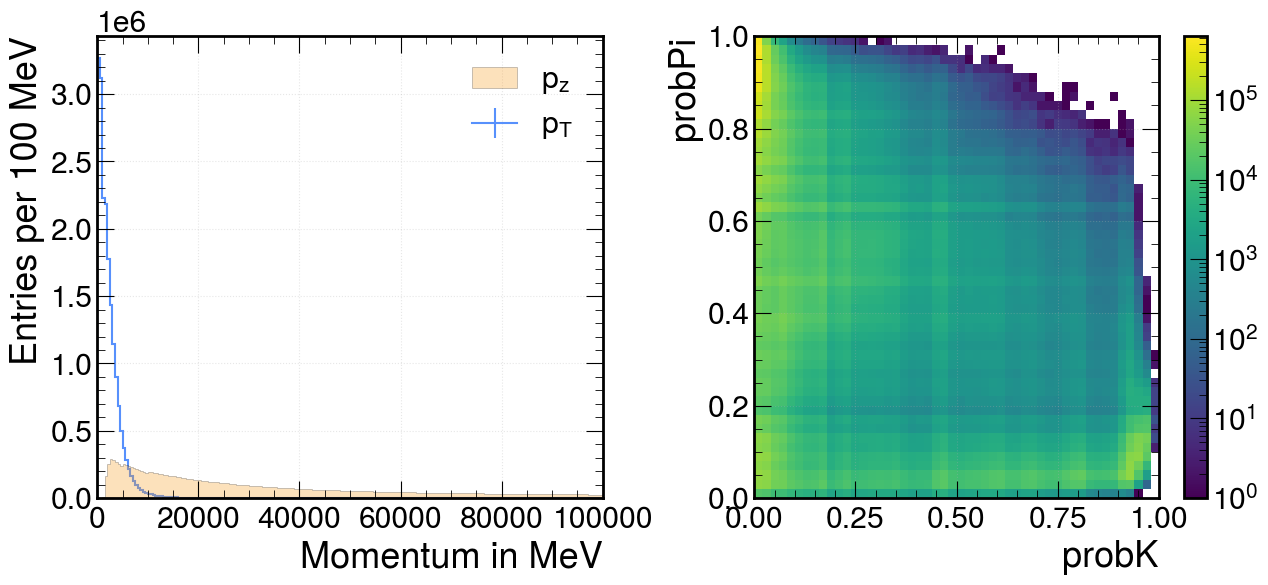

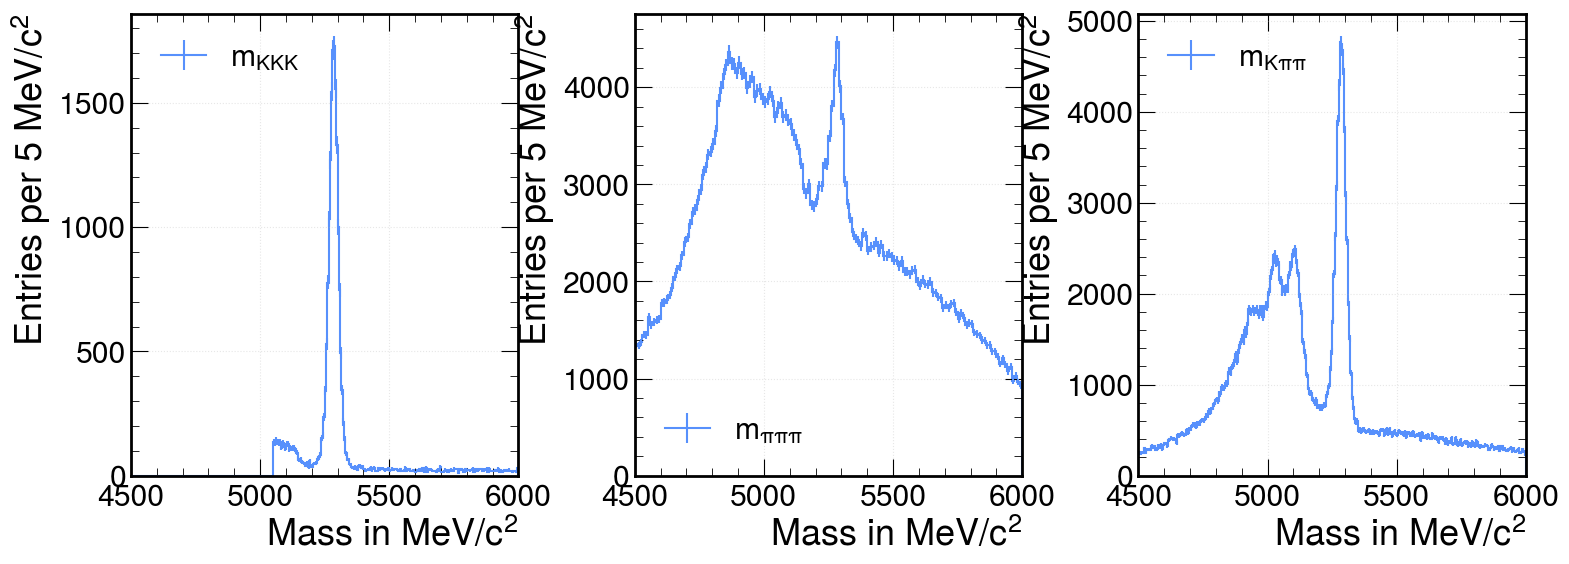

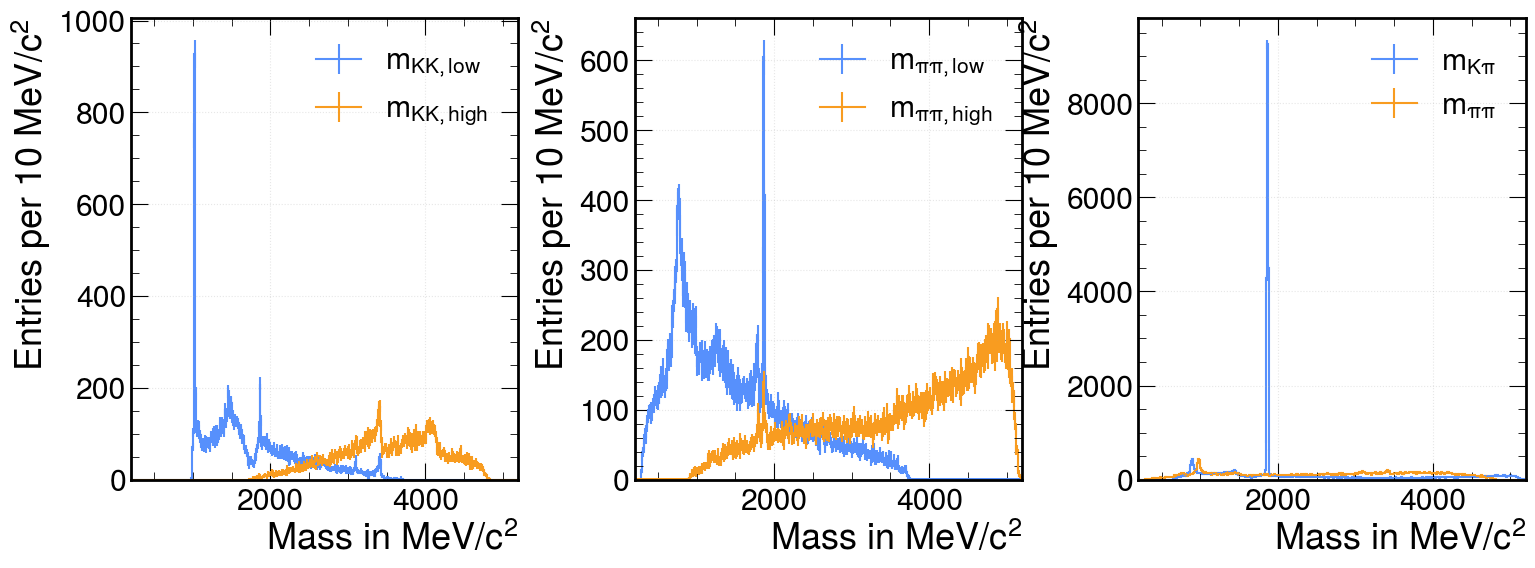

All histograms created successfully with DIRECT RDataFrame usage!
Done!


In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep  
import numpy as np
import ROOT

print("Creating histograms with ROOT RDataFrame...")

# Enable implicit multi-threading in ROOT
plt.style.use(hep.style.ROOT)

# # Get actual values from RResultPtr objects
# kkk_selected_val = kkk_selected.GetValue()
# pipipi_selected_val = pipipi_selected.GetValue()
# kpi_selected_val = kpi_selected.GetValue()
# kkk_mass_window_val = kkk_mass_window.GetValue()
# pipipi_mass_window_val = pipipi_mass_window.GetValue()
# kpi_mass_window_val = kpi_mass_window.GetValue()

def print_histogram_details(hist, name, max_entries=20):
    """Print detailed information about histogram contents"""
    print(f"\n{'='*60}")
    print(f"HISTOGRAM DETAILS: {name}")
    print(f"{'='*60}")
    print(f"Total entries: {hist.GetEntries()}")
    print(f"Number of bins: {hist.GetNbinsX()}")
    print(f"X-axis range: [{hist.GetXaxis().GetXmin():.2f}, {hist.GetXaxis().GetXmax():.2f}]")
    print(f"Bin width: {hist.GetBinWidth(1):.2f}")
    print(f"Mean: {hist.GetMean():.2f}")
    print(f"RMS: {hist.GetRMS():.2f}")
    
    # Find non-empty bins
    non_empty_bins = []
    for i in range(1, hist.GetNbinsX() + 1):
        content = hist.GetBinContent(i)
        if content > 0:
            bin_center = hist.GetBinCenter(i)
            bin_low = hist.GetBinLowEdge(i)
            bin_high = hist.GetBinLowEdge(i) + hist.GetBinWidth(i)
            non_empty_bins.append((i, bin_center, bin_low, bin_high, content))
    
    print(f"Non-empty bins: {len(non_empty_bins)}")
    print(f"\nShowing first {min(max_entries, len(non_empty_bins))} non-empty bins:")
    print(f"{'Bin#':<6} {'Center':<12} {'Low Edge':<12} {'High Edge':<12} {'Content':<10}")
    print("-" * 62)
    
    for i, (bin_num, center, low, high, content) in enumerate(non_empty_bins[:max_entries]):
        print(f"{bin_num:<6} {center:<12.2f} {low:<12.2f} {high:<12.2f} {content:<10.1f}")
    
    if len(non_empty_bins) > max_entries:
        print(f"... and {len(non_empty_bins) - max_entries} more non-empty bins")

def print_2d_histogram_details(hist, name, max_entries=20):
    """Print detailed information about 2D histogram contents"""
    print(f"\n{'='*60}")
    print(f"2D HISTOGRAM DETAILS: {name}")
    print(f"{'='*60}")
    print(f"Total entries: {hist.GetEntries()}")
    print(f"X bins: {hist.GetNbinsX()}, Y bins: {hist.GetNbinsY()}")
    print(f"X-axis range: [{hist.GetXaxis().GetXmin():.3f}, {hist.GetXaxis().GetXmax():.3f}]")
    print(f"Y-axis range: [{hist.GetYaxis().GetXmin():.3f}, {hist.GetYaxis().GetXmax():.3f}]")
    print(f"X bin width: {hist.GetXaxis().GetBinWidth(1):.3f}")
    print(f"Y bin width: {hist.GetYaxis().GetBinWidth(1):.3f}")
    
    # Find non-empty bins
    non_empty_bins = []
    for i in range(1, hist.GetNbinsX() + 1):
        for j in range(1, hist.GetNbinsY() + 1):
            content = hist.GetBinContent(i, j)
            if content > 0:
                x_center = hist.GetXaxis().GetBinCenter(i)
                y_center = hist.GetYaxis().GetBinCenter(j)
                non_empty_bins.append((i, j, x_center, y_center, content))
    
    print(f"Non-empty bins: {len(non_empty_bins)}")
    print(f"\nShowing first {min(max_entries, len(non_empty_bins))} non-empty bins:")
    print(f"{'X Bin':<6} {'Y Bin':<6} {'X Center':<10} {'Y Center':<10} {'Content':<10}")
    print("-" * 52)
    
    for i, (x_bin, y_bin, x_center, y_center, content) in enumerate(non_empty_bins[:max_entries]):
        print(f"{x_bin:<6} {y_bin:<6} {x_center:<10.3f} {y_center:<10.3f} {content:<10.1f}")
    
    if len(non_empty_bins) > max_entries:
        print(f"... and {len(non_empty_bins) - max_entries} more non-empty bins")

# ======================
# 1. pT ve pZ histogramları
# ======================
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig1.subplots_adjust(wspace=0.3)

print('Plotting 1D histogram - pT and pZ')

# ROOT histogramları oluştur - DOĞRUDAN KULLAN, yeniden oluşturma!
print("Creating pT and pZ histograms from RDataFrame...")

# Histogramları birleştir - DOĞRU YÖNTEMİ
# h_pT = ROOT.TH1F("h_pT", "p_{T} Distribution", 200, 0, 100000)
# h_pZ = ROOT.TH1F("h_pZ", "p_{z} Distribution", 200, 0, 100000)

# DOĞRU YÖNTEM: Add() kullan, Fill() kullanma!
# for h_source in [h_pT1, h_pT2, h_pT3]:
#     h_temp = h_source.GetValue()
#     h_pT.Add(h_temp)

# for h_source in [h_pZ1, h_pZ2, h_pZ3]:
#     h_temp = h_source.GetValue()
#     h_pZ.Add(h_temp)

# Print detailed information for pT and pZ histograms
print_histogram_details(h_pT, "pT Distribution (Combined H1+H2+H3)", max_entries=30)
print_histogram_details(h_pZ, "pZ Distribution (Combined H1+H2+H3)", max_entries=30)

# mplhep ile histogramları çiz
hep.histplot([h_pT], ax=ax1[0], histtype='step', label='$p_{T}$', linewidth=1.5)
hep.histplot([h_pZ], ax=ax1[0], histtype='fill', label='$p_{z}$', alpha=0.3, edgecolor='black', linewidth=0.5)

ax1[0].set_xlabel('Momentum in MeV')
ax1[0].set_ylabel('Entries per 100 MeV')
ax1[0].legend()
ax1[0].grid(True, alpha=0.3)
ax1[0].set_xlim(0, 100000)

print('Plotting 2D histogram - probK vs probPi')

# 2D histogram - DOĞRUDAN KULLAN
# h2d_prob = ROOT.TH2F("h2d_prob", "probK vs probPi;probK;probPi", 50, 0, 1, 50, 0, 1)

# for h_source in [h2d_prob1, h2d_prob2, h2d_prob3]:
#     h_temp = h_source.GetValue()
#     h2d_prob.Add(h_temp)

# Print detailed information for 2D probability histogram
print_2d_histogram_details(h2d_prob, "probK vs probPi (Combined H1+H2+H3)", max_entries=50)

# mplhep ile 2D histogram çiz
try:
    hep.hist2dplot(h2d_prob, ax=ax1[1], norm=colors.LogNorm(), cmin=1)
except:
    x_bins = np.linspace(0, 1, 51)
    y_bins = np.linspace(0, 1, 51)
    z_data = np.array([[h2d_prob.GetBinContent(i, j) for j in range(1, 51)] 
                      for i in range(1, 51)])
    
    im = ax1[1].pcolormesh(x_bins, y_bins, z_data.T, norm=colors.LogNorm(vmin=1), shading='auto')
    plt.colorbar(im, ax=ax1[1])

ax1[1].set_xlabel('probK')
ax1[1].set_ylabel('probPi')
ax1[1].set_xlim(0, 1)
ax1[1].set_ylim(0, 1)
ax1[1].grid(True, alpha=0.3)

plt.savefig('momentum_prob_histograms.pdf')
print('Saved momentum_prob_histograms.pdf')

# ======================
# 2. Üçlü kütle dağılımları - DOĞRUDAN KULLAN
# ======================
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig2.subplots_adjust(wspace=0.3)

print('Plotting triple mass distributions')

# DOĞRUDAN RDataFrame histogramlarını kullan, yeniden oluşturma!
mass_configs = [
    (h_kkk_mass.GetValue(), kkk_selected_val, r'$m_{KKK}$', ax2[0], "KKK Mass Distribution"),
    (h_pipipi_mass.GetValue(), pipipi_selected_val, r'$m_{\pi\pi\pi}$', ax2[1], "πππ Mass Distribution"),
    (h_kpi_mass.GetValue(), kpi_selected_val, r'$m_{K\pi\pi}$', ax2[2], "Kππ Mass Distribution")
]

for hist_value, count, label, ax, desc in mass_configs:
    if count > 0:
        # DOĞRUDAN orijinal histogramı kullan
        print_histogram_details(hist_value, desc, max_entries=25)
        hep.histplot([hist_value], ax=ax, histtype='step', label=label)
        print(f"{label} mass histogram entries: {hist_value.GetEntries()}")
    else:
        print(f"Warning: No events to plot for {label}")

for i in range(3):
    ax2[i].set_xlabel('Mass in MeV/$c^2$')
    ax2[i].set_ylabel('Entries per 5 MeV/$c^2$')
    ax2[i].legend()
    ax2[i].grid(True, alpha=0.3)
    ax2[i].set_xlim(4500, 6000)

plt.savefig('triple_mass_distributions.pdf')
print('Saved triple_mass_distributions.pdf')

# ======================
# 3. İkili kütle dağılımları - DOĞRUDAN KULLAN
# ======================
fig3, ax3 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig3.subplots_adjust(wspace=0.3)

print('Plotting pair mass distributions')

# DOĞRUDAN RDataFrame histogramlarını kullan
pair_configs = [
    ([h_mKKlow.GetValue(), h_mKKhigh.GetValue()], kkk_mass_window_val, 
     [r'$m_{KK,low}$', r'$m_{KK,high}$'], ax3[0],
     ["KK Low Mass Distribution", "KK High Mass Distribution"]),
    
    ([h_mpipilow.GetValue(), h_mpipihigh.GetValue()], pipipi_mass_window_val, 
     [r'$m_{\pi\pi,low}$', r'$m_{\pi\pi,high}$'], ax3[1],
     ["ππ Low Mass Distribution", "ππ High Mass Distribution"]),
    
    ([h_mKpi.GetValue(), h_mpipi_kpi.GetValue()], kpi_mass_window_val, 
     [r'$m_{K\pi}$', r'$m_{\pi\pi}$'], ax3[2],
     ["Kπ Mass Distribution", "ππ Mass Distribution (in Kππ)"])
]

for h_list, count, labels, ax, descriptions in pair_configs:
    if count > 0:
        for i, (hist_value, label, desc) in enumerate(zip(h_list, labels, descriptions)):
            # DOĞRUDAN orijinal histogramı kullan
            print_histogram_details(hist_value, desc, max_entries=25)
            hep.histplot([hist_value], ax=ax, histtype='step', label=label, linewidth=1.5)
            print(f"{label} histogram entries: {hist_value.GetEntries()}")
    else:
        print(f"Warning: No mass window events for {labels[0].split('_')[0]} histograms")

for i in range(3):
    ax3[i].set_xlabel('Mass in MeV/$c^2$')
    ax3[i].set_ylabel('Entries per 10 MeV/$c^2$')
    ax3[i].legend()
    ax3[i].grid(True, alpha=0.3)
    ax3[i].set_xlim(200, 5200)

plt.savefig('pair_mass_distributions.pdf')
print('Saved pair_mass_distributions.pdf')

plt.show()

print("All histograms created successfully with DIRECT RDataFrame usage!")
print('Done!')

In [12]:
# 4. Significance calculation for πππ - Exact original replication
# ======================
print("Calculating significance for πππ channel...")

# Create histogram with EXACTLY the same parameters as original
# h_pipipi_original = df_pipipi_selected.Histo1D(("h_pipipi_original", "πππ mass original", 150, 4500, 6000), "PIPIPI_valid_mass")
# pipipi_hist = h_pipipi_original.GetPtr()

# Orijinal koddaki gibi values_mpipipi array'ini oluştur
# TODO
values_mpipipi = pipipi_hist.counts()
# values_mpipipi = []
# for i in range(1, 151):  # 150 bin
#     values_mpipipi.append(pipipi_hist.GetBinContent(i))

# Orijinal kodun tam aynısı:
snb = values_mpipipi[78]  # Python 0-based index: 78
b = (values_mpipipi[69] + values_mpipipi[87]) / 2
s = snb - b
significance = s / np.sqrt(snb) if snb > 0 else 0

print('Kmax', probK_max, 'piAll', probpi_all, 'piSum', probpi_sum, 
      'S', s, 'B', b, 'S/B', s/b, 'sig', significance)

Calculating significance for πππ channel...
Kmax 0.7 piAll 0.6 piSum 2.4 S 1894.5 B 2569.5 S/B 0.7373029772329247 sig 28.355187057477085


Creating narrow range histograms (5000-5600 MeV)...
!!! histogram déjà conforme au protocole !!!
KKK narrow histogram entries: 22754.0
!!! histogram déjà conforme au protocole !!!
πππ narrow histogram entries: 436445.0
!!! histogram déjà conforme au protocole !!!
Kππ narrow histogram entries: 286813.0
Saved narrow_mass_distributions.pdf


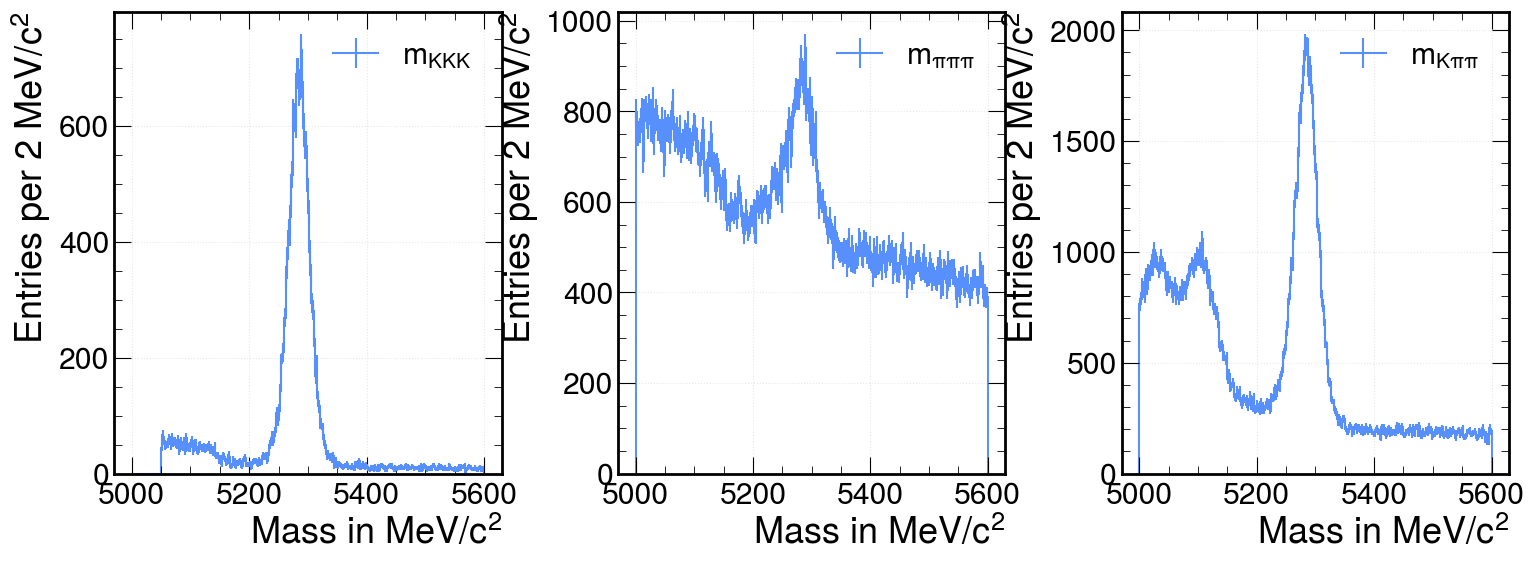

In [13]:
print("Creating narrow range histograms (5000-5600 MeV)...")

fig4, ax4 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig4.subplots_adjust(wspace=0.3)

# Get actual values from RResultPtr objects
# kkk_selected_val = kkk_selected.GetValue()
# pipipi_selected_val = pipipi_selected.GetValue()
# kpi_selected_val = kpi_selected.GetValue()

# # Create narrow range histograms
# h_kkk_narrow = df_kkk_selected.Histo1D(("h_kkk_narrow", "KKK mass narrow", 300, 5000, 5600), "KKK_valid_mass")
# h_pipipi_narrow = df_pipipi_selected.Histo1D(("h_pipipi_narrow", "πππ mass narrow", 300, 5000, 5600), "PIPIPI_valid_mass")
# h_kpi_narrow = df_kpi_selected.Histo1D(("h_kpi_narrow", "Kππ mass narrow", 300, 5000, 5600), "kpi_valid_mass")

# Plot narrow range histograms
if kkk_selected_val > 0:
    hep.histplot(h_kkk_narrow.GetPtr(), ax=ax4[0], histtype='step', label=r'$m_{KKK}$', linewidth=1.5)
    print(f"KKK narrow histogram entries: {h_kkk_narrow.GetPtr().GetEntries()}")

if pipipi_selected_val > 0:
    hep.histplot(h_pipipi_narrow.GetPtr(), ax=ax4[1], histtype='step', label=r'$m_{\pi\pi\pi}$', linewidth=1.5)
    print(f"πππ narrow histogram entries: {h_pipipi_narrow.GetPtr().GetEntries()}")

if kpi_selected_val > 0:
    hep.histplot(h_kpi_narrow.GetPtr(), ax=ax4[2], histtype='step', label=r'$m_{K\pi\pi}$', linewidth=1.5)
    print(f"Kππ narrow histogram entries: {h_kpi_narrow.GetPtr().GetEntries()}")

# Set labels and save
for i in range(3):
    ax4[i].set_xlabel('Mass in MeV/$c^2$')
    ax4[i].set_ylabel('Entries per 2 MeV/$c^2$')
    ax4[i].legend()
    ax4[i].grid(True, alpha=0.3)

plt.savefig('narrow_mass_distributions.pdf')
print('Saved narrow_mass_distributions.pdf')

Performing fitting analysis...
Fitting KKK mass distribution...
Fit results with chi2/ndf 310.37500446721015 / 188
Par 1: 2404.201387 +/- 798.258034
Par 2: 23.490863 +/- 7.494589
Par 3: 28962.300303 +/- 191.857797
Par 4: 5284.995241 +/- 0.110558
Par 5: 17.403566 +/- 0.118004
Par 6: 35.737690 +/- 7.081628
Par 7: 388.907301 +/- 96.135945
Fitting πππ mass distribution...
Fit results with chi2/ndf 282.6476054509443 / 200
Par 1: 7902.156195 +/- 1430.599238
Par 2: 28.800148 +/- 4.039612
Par 3: 18679.082140 +/- 657.002658
Par 4: 5282.067621 +/- 0.670740
Par 5: 22.742922 +/- 0.756708
Par 6: 677.880696 +/- 13.765794
Par 7: 1171.540944 +/- 75.471384
Fitting Kππ mass distribution...
Fit results with chi2/ndf 374.7147260076972 / 200
Par 1: 43600.887243 +/- 1432.925145
Par 2: 27.829660 +/- 0.695860
Par 3: 76177.989709 +/- 546.601304
Par 4: 5284.661589 +/- 0.125179
Par 5: 18.803726 +/- 0.135347
Par 6: 471.786214 +/- 17.566581
Par 7: 477.659792 +/- 25.730815
Creating fit plots...
Saved fit_results.pd

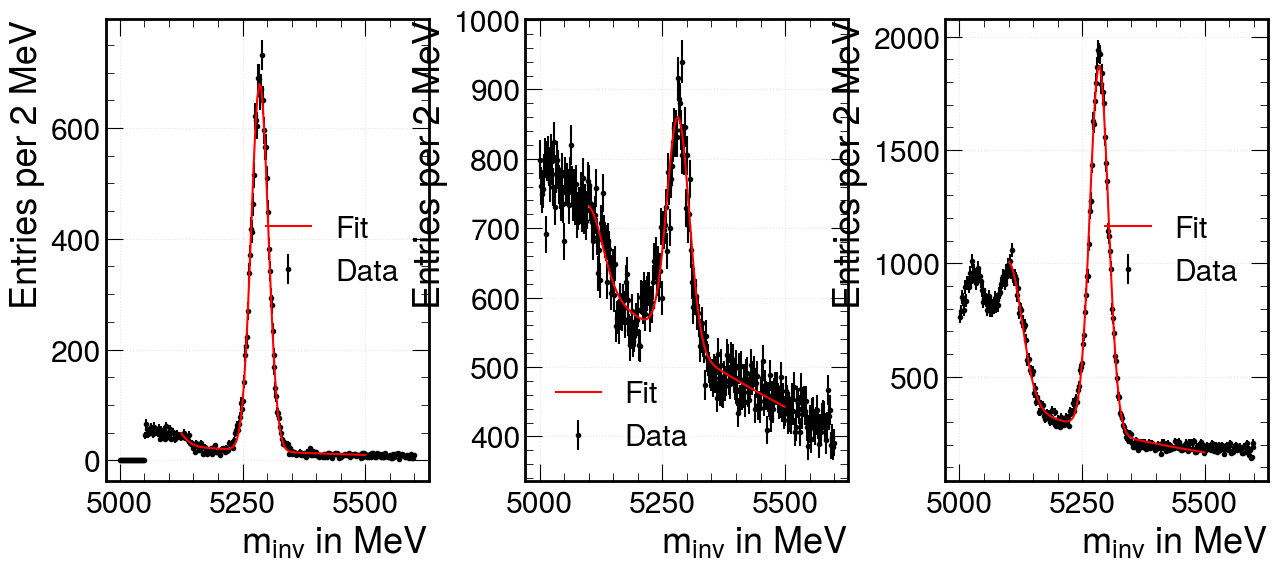

Fitting analysis completed!
Done!


In [14]:
print("Performing fitting analysis...")

# Import necessary modules for fitting
from scipy.optimize import curve_fit

# Get actual values from RResultPtr objects
# kkk_selected_val = kkk_selected.GetValue()
# pipipi_selected_val = pipipi_selected.GetValue()
# kpi_selected_val = kpi_selected.GetValue()

# Define fitting functions (same as original)
def exponential(x, norm, decay):
    return np.array(norm * np.exp(-(x-5000)/decay))

def constant(x, norm):
    return np.array(norm)

def gauss(x, norm, mu, sigma):
    return np.array(norm / np.sqrt(2*np.pi) / sigma * np.exp(-(x-mu)**2 / 2 / sigma**2))

def fit_function(x, norm4, sigma4, normG, muG, sigmaG, normE, decay):
    return np.array(gauss(x, norm4, 5100, sigma4) + gauss(x, normG, muG, sigmaG) + exponential(x, normE, decay))

def fit_data(hist_ptr, minX, maxX, p0):
    """Extract data from ROOT histogram and perform fit"""
    n_bins = hist_ptr.GetNbinsX()
    bin_centres = []
    values = []
    
    # Extract bin centers and values from ROOT histogram
    for i in range(1, n_bins + 1):
        bin_center = hist_ptr.GetBinCenter(i)
        bin_content = hist_ptr.GetBinContent(i)
        bin_centres.append(bin_center)
        values.append(bin_content)
    
    # Reduce range to fit only part of curve
    bin_centres_red = []
    values_red = []
    for c, v in zip(bin_centres, values):
        if c < minX or c > maxX:
            continue
        bin_centres_red.append(c)
        values_red.append(v)
    
    # Execute the fit
    if len(bin_centres_red) > 7:  # Need enough points for 7-parameter fit
        try:
            coeff_fit, cov_fit = curve_fit(fit_function, bin_centres_red, values_red, p0)
            fit_vals = [fit_function(x, coeff_fit[0], coeff_fit[1], coeff_fit[2], 
                                   coeff_fit[3], coeff_fit[4], coeff_fit[5], coeff_fit[6]) 
                       for x in bin_centres_red]
            
            # Calculate chi2
            chi2parts = np.array((np.divide(np.array(values_red) - np.array(fit_vals), 
                               np.sqrt(values_red), 
                               out=np.zeros_like(values_red), 
                               where=np.array(values_red) != 0))**2)  # Add small epsilon to avoid division by zero
            chi2 = np.sum(chi2parts)
            
            return coeff_fit, cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)
        except Exception as e:
            print(f"Fit failed: {e}")
            return None, None, bin_centres, bin_centres_red, 0, 0
    else:
        print("Not enough data points for fitting")
        return None, None, bin_centres, bin_centres_red, 0, 0

def print_results(coeff, cov, chi2, ndf):
    """Print fit results"""
    if coeff is not None and cov is not None:
        perr = np.sqrt(np.diag(cov))  # extract errors from covariance matrix
        print('Fit results with chi2/ndf', chi2, '/', ndf)
        parcount = 0
        for p, e in zip(coeff, perr):
            parcount += 1
            print('Par {:d}: {:f} +/- {:f}'.format(parcount, p, e))
    else:
        print("Fit failed - no results to display")

def plot_results(ax, bin_centres, bin_centres_red, values, coeff_fit, fname):
    """Plot fit results"""
    # Plot the data with error bars
    ax.errorbar(bin_centres, values, yerr=np.sqrt(np.array(values) + 1e-10), 
               linestyle='', marker='.', markerfacecolor='k', markeredgecolor='k', 
               ecolor='k', label='Data')
    
    # Plot the fit if successful
    if coeff_fit is not None and len(bin_centres_red) > 0:
        x_fit = np.linspace(bin_centres_red[0], bin_centres_red[-1], 100)
        y_fit = fit_function(x_fit, coeff_fit[0], coeff_fit[1], coeff_fit[2], 
                           coeff_fit[3], coeff_fit[4], coeff_fit[5], coeff_fit[6])
        ax.plot(x_fit, y_fit, label='Fit', color='r', zorder=10)
    
    # Plot decoration
    ax.legend()# 
    ax.set_xlabel(r'$m_{inv}$ in MeV')
    ax.set_ylabel('Entries per 2 MeV')
    ax.grid(True, alpha=0.3)

# Perform fits on narrow range histograms
print("Fitting KKK mass distribution...")
if kkk_selected_val > 0:
    coeff_KKK_fit, cov_KKK_fit, bin_centres_KKK, bin_centres_red_KKK, chi2_KKK, ndf_KKK = \
        fit_data(h_kkk_narrow.GetPtr(), 5125, 5500, [2000, 30, 30000, 5285, 20, 40, 500])
    print_results(coeff_KKK_fit, cov_KKK_fit, chi2_KKK, ndf_KKK)

print("Fitting πππ mass distribution...")
if pipipi_selected_val > 0:
    coeff_pipipi_fit, cov_pipipi_fit, bin_centres_pipipi, bin_centres_red_pipipi, chi2_pipipi, ndf_pipipi = \
        fit_data(h_pipipi_narrow.GetPtr(), 5100, 5500, [8000, 30, 10000, 5285, 20, 1000, 500])
    print_results(coeff_pipipi_fit, cov_pipipi_fit, chi2_pipipi, ndf_pipipi)

print("Fitting Kππ mass distribution...")
if kpi_selected_val > 0:
    coeff_Kpipi_fit, cov_Kpipi_fit, bin_centres_Kpipi, bin_centres_red_Kpipi, chi2_Kpipi, ndf_Kpipi = \
        fit_data(h_kpi_narrow.GetPtr(), 5100, 5500, [15000, 30, 60000, 5285, 20, 400, 500])
    print_results(coeff_Kpipi_fit, cov_Kpipi_fit, chi2_Kpipi, ndf_Kpipi)

# Plot fit results
print("Creating fit plots...")
fig5, ax5 = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig5.subplots_adjust(wspace=0.3)

if kkk_selected_val > 0 and 'coeff_KKK_fit' in locals():
    # Extract values from ROOT histogram for plotting
    kkk_hist = h_kkk_narrow.GetPtr()
    values_KKK = [kkk_hist.GetBinContent(i) for i in range(1, kkk_hist.GetNbinsX() + 1)]
    plot_results(ax5[0], bin_centres_KKK, bin_centres_red_KKK, values_KKK, coeff_KKK_fit, 'mfit_KKK.pdf')

if pipipi_selected_val > 0 and 'coeff_pipipi_fit' in locals():
    # Extract values from ROOT histogram for plotting
    pipipi_hist = h_pipipi_narrow.GetPtr()
    values_pipipi = [pipipi_hist.GetBinContent(i) for i in range(1, pipipi_hist.GetNbinsX() + 1)]
    plot_results(ax5[1], bin_centres_pipipi, bin_centres_red_pipipi, values_pipipi, coeff_pipipi_fit, 'mfit_pipipi.pdf')

if kpi_selected_val > 0 and 'coeff_Kpipi_fit' in locals():
    # Extract values from ROOT histogram for plotting
    kpi_hist = h_kpi_narrow.GetPtr()
    values_Kpipi = [kpi_hist.GetBinContent(i) for i in range(1, kpi_hist.GetNbinsX() + 1)]
    plot_results(ax5[2], bin_centres_Kpipi, bin_centres_red_Kpipi, values_Kpipi, coeff_Kpipi_fit, 'mfit_Kpipi.pdf')

plt.savefig('fit_results.pdf')
print('Saved fit_results.pdf')

plt.show()

print("Fitting analysis completed!")
print('Done!')

In [15]:
end_time = time.time()
elapsed = end_time - start_time
minutes = int(elapsed // 60)
seconds = int(elapsed % 60)
print(f"Total execution time: {minutes} min {seconds} sec")

Total execution time: 0 min 54 sec
